In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
train_data = np.load('data/bert/train_bert_embeddings_with_labels.npy')
test_data = np.load('data/bert/test_bert_embeddings_with_labels.npy')

X_train = train_data[:, :-1]
y_train = train_data[:, -1]

X_test = test_data[:, :-1]
y_test = test_data[:, -1]

In [16]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [4]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [4]:
del train_data, test_data, X_train, X_test

In [5]:
# Create TensorDatasets
# train_dataset = TensorDataset(X_train_tensor)
# test_dataset = TensorDataset(X_test_tensor)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


batch_size = 8192 
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Various Autoencoder architectures tested

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoded_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoded_dim),
            nn.ReLU(True))
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoded_dim, input_dim),
            nn.ReLU(True))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoded_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512, encoded_dim),
            nn.BatchNorm1d(encoded_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoded_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, input_dim),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [8]:
input_dim = 768 
encoded_dim = 128
autoencoder = Autoencoder(input_dim, encoded_dim)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

autoencoder = autoencoder.to(device)


Using device: mps


In [10]:
from tqdm import tqdm

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-5)
num_epochs = 30 


In [11]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0
    for data in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]', unit='batch'):
        inputs = data[0].to(device)

        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    autoencoder.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            inputs = data[0].to(device)
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')


Epoch 1/30 [Training]: 100%|██████████| 157/157 [00:07<00:00, 21.93batch/s]


Epoch 1, Train Loss: 0.2073, Test Loss: 0.1634


Epoch 2/30 [Training]: 100%|██████████| 157/157 [00:06<00:00, 22.89batch/s]


Epoch 2, Train Loss: 0.1643, Test Loss: 0.1401


Epoch 3/30 [Training]: 100%|██████████| 157/157 [00:06<00:00, 23.05batch/s]


Epoch 3, Train Loss: 0.1364, Test Loss: 0.1280


Epoch 4/30 [Training]: 100%|██████████| 157/157 [00:06<00:00, 22.55batch/s]


Epoch 4, Train Loss: 0.1245, Test Loss: 0.1204


Epoch 5/30 [Training]: 100%|██████████| 157/157 [00:06<00:00, 22.85batch/s]


Epoch 5, Train Loss: 0.1114, Test Loss: 0.1074


Epoch 6/30 [Training]: 100%|██████████| 157/157 [00:06<00:00, 22.71batch/s]


Epoch 6, Train Loss: 0.0995, Test Loss: 0.0977


Epoch 7/30 [Training]: 100%|██████████| 157/157 [00:07<00:00, 22.22batch/s]


Epoch 7, Train Loss: 0.0916, Test Loss: 0.0893


Epoch 8/30 [Training]: 100%|██████████| 157/157 [00:06<00:00, 22.44batch/s]


Epoch 8, Train Loss: 0.0862, Test Loss: 0.0842


Epoch 9/30 [Training]: 100%|██████████| 157/157 [00:07<00:00, 22.41batch/s]


Epoch 9, Train Loss: 0.0823, Test Loss: 0.0806


Epoch 10/30 [Training]: 100%|██████████| 157/157 [00:07<00:00, 22.19batch/s]


Epoch 10, Train Loss: 0.0789, Test Loss: 0.0762


Epoch 11/30 [Training]: 100%|██████████| 157/157 [00:06<00:00, 22.48batch/s]


Epoch 11, Train Loss: 0.0756, Test Loss: 0.0743


Epoch 12/30 [Training]: 100%|██████████| 157/157 [00:06<00:00, 22.54batch/s]


Epoch 12, Train Loss: 0.0727, Test Loss: 0.0717


Epoch 13/30 [Training]: 100%|██████████| 157/157 [00:06<00:00, 22.59batch/s]


Epoch 13, Train Loss: 0.0701, Test Loss: 0.0687


Epoch 14/30 [Training]: 100%|██████████| 157/157 [00:06<00:00, 22.51batch/s]


Epoch 14, Train Loss: 0.0677, Test Loss: 0.0669


Epoch 15/30 [Training]: 100%|██████████| 157/157 [00:07<00:00, 22.35batch/s]


Epoch 15, Train Loss: 0.0654, Test Loss: 0.0635


Epoch 16/30 [Training]: 100%|██████████| 157/157 [00:07<00:00, 22.37batch/s]


Epoch 16, Train Loss: 0.0632, Test Loss: 0.0616


Epoch 17/30 [Training]: 100%|██████████| 157/157 [00:07<00:00, 22.26batch/s]


Epoch 17, Train Loss: 0.0611, Test Loss: 0.0593


Epoch 18/30 [Training]: 100%|██████████| 157/157 [00:06<00:00, 22.45batch/s]


Epoch 18, Train Loss: 0.0590, Test Loss: 0.0579


Epoch 19/30 [Training]: 100%|██████████| 157/157 [00:06<00:00, 22.76batch/s]


Epoch 19, Train Loss: 0.0571, Test Loss: 0.0553


Epoch 20/30 [Training]: 100%|██████████| 157/157 [00:06<00:00, 22.69batch/s]


Epoch 20, Train Loss: 0.0551, Test Loss: 0.0535


Epoch 21/30 [Training]: 100%|██████████| 157/157 [00:07<00:00, 22.35batch/s]


Epoch 21, Train Loss: 0.0531, Test Loss: 0.0511


Epoch 22/30 [Training]: 100%|██████████| 157/157 [00:06<00:00, 22.88batch/s]


Epoch 22, Train Loss: 0.0509, Test Loss: 0.0499


Epoch 23/30 [Training]: 100%|██████████| 157/157 [00:07<00:00, 22.30batch/s]


Epoch 23, Train Loss: 0.0485, Test Loss: 0.0474


Epoch 24/30 [Training]: 100%|██████████| 157/157 [00:06<00:00, 22.52batch/s]


Epoch 24, Train Loss: 0.0448, Test Loss: 0.0400


Epoch 25/30 [Training]: 100%|██████████| 157/157 [00:07<00:00, 22.21batch/s]


Epoch 25, Train Loss: 0.0354, Test Loss: 0.0295


Epoch 26/30 [Training]: 100%|██████████| 157/157 [00:06<00:00, 22.60batch/s]


Epoch 26, Train Loss: 0.0285, Test Loss: 0.0239


Epoch 27/30 [Training]: 100%|██████████| 157/157 [00:07<00:00, 22.42batch/s]


Epoch 27, Train Loss: 0.0239, Test Loss: 0.0207


Epoch 28/30 [Training]: 100%|██████████| 157/157 [00:07<00:00, 22.19batch/s]


Epoch 28, Train Loss: 0.0199, Test Loss: 0.0166


Epoch 29/30 [Training]: 100%|██████████| 157/157 [00:07<00:00, 22.31batch/s]


Epoch 29, Train Loss: 0.0163, Test Loss: 0.0134


Epoch 30/30 [Training]: 100%|██████████| 157/157 [00:07<00:00, 22.37batch/s]


Epoch 30, Train Loss: 0.0132, Test Loss: 0.0106


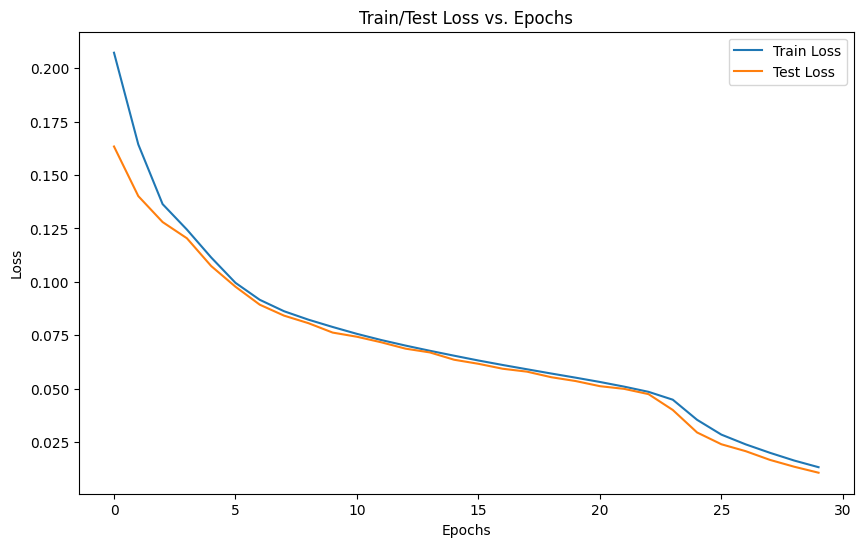

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train/Test Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

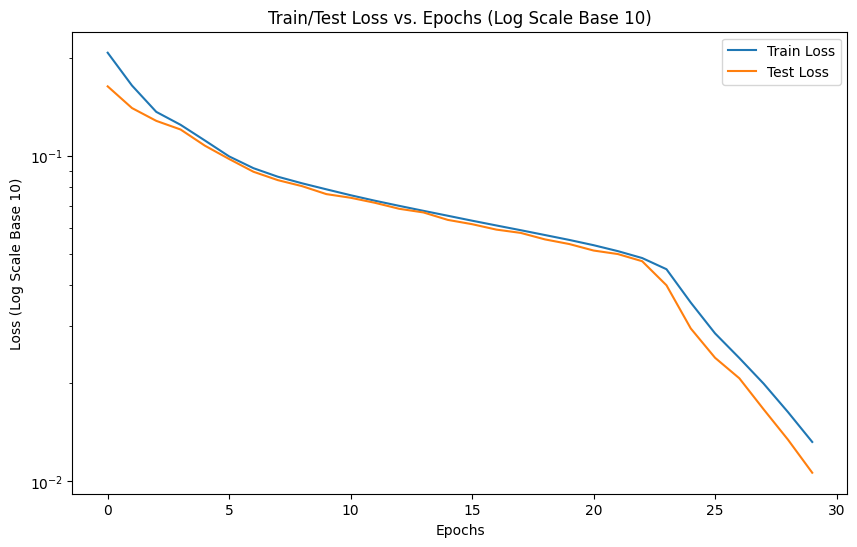

In [13]:
# Plotting the training and testing loss on a log scale with base 10
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train/Test Loss vs. Epochs (Log Scale Base 10)')
plt.xlabel('Epochs')
plt.ylabel('Loss (Log Scale Base 10)')
plt.yscale('log')
plt.legend()
plt.show()


## Final Implementation

In [4]:
X_train = torch.tensor(train_data[:, :-1], dtype=torch.float32)
y_train = torch.tensor(train_data[:, -1], dtype=torch.long)

X_test = torch.tensor(test_data[:, :-1], dtype=torch.float32)
y_test = torch.tensor(test_data[:, -1], dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 2048
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [2]:
class MultiTaskAutoencoder(nn.Module):
    def __init__(self, input_dim, encoded_dim, num_classes):
        super(MultiTaskAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, encoded_dim),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoded_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, input_dim),
            nn.ReLU(True)
        )
        self.classifier = nn.Sequential(
            nn.Linear(encoded_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        classified = self.classifier(encoded)
        return reconstructed, classified


In [3]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = 'cpu'
print(f"Using device: {device}")

# Initialize the model
num_classes = 2  # Set the number of classes
autoencoder = MultiTaskAutoencoder(input_dim=768, encoded_dim=128, num_classes=num_classes).to(device)

# Loss functions
reconstruction_criterion = nn.MSELoss()
classification_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00007)


Using device: cpu


In [6]:
pytorch_total_params = sum(p.numel() for p in autoencoder.parameters())

In [7]:
pytorch_total_params

952962

In [15]:
num_epochs = 30

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    autoencoder.train()
    total_train_loss = 0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]', unit='batch'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        reconstructed, classified = autoencoder(inputs)

        reconstruction_loss = reconstruction_criterion(reconstructed, inputs)
        classification_loss = classification_criterion(classified, labels)
        total_loss = reconstruction_loss + classification_loss

        total_loss.backward()
        optimizer.step()
        total_train_loss += total_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    autoencoder.eval()
    total_test_loss = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Testing]', unit='batch'):
            inputs, labels = inputs.to(device), labels.to(device)
            reconstructed, classified = autoencoder(inputs)

            reconstruction_loss = reconstruction_criterion(reconstructed, inputs)
            classification_loss = classification_criterion(classified, labels)
            total_loss = reconstruction_loss + classification_loss

            total_test_loss += total_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')


Epoch 1/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 82.76batch/s]


Epoch 1, Train Loss: 0.5737, Test Loss: 0.4633


Epoch 2/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 85.71batch/s]


Epoch 2, Train Loss: 0.4544, Test Loss: 0.4473


Epoch 3/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 83.02batch/s]


Epoch 3, Train Loss: 0.4449, Test Loss: 0.4412


Epoch 4/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 86.78batch/s]


Epoch 4, Train Loss: 0.4395, Test Loss: 0.4365


Epoch 5/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 84.99batch/s]


Epoch 5, Train Loss: 0.4353, Test Loss: 0.4338


Epoch 6/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 83.11batch/s]


Epoch 6, Train Loss: 0.4320, Test Loss: 0.4309


Epoch 7/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 83.97batch/s]


Epoch 7, Train Loss: 0.4291, Test Loss: 0.4276


Epoch 8/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 81.71batch/s]


Epoch 8, Train Loss: 0.4265, Test Loss: 0.4271


Epoch 9/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 83.13batch/s]


Epoch 9, Train Loss: 0.4244, Test Loss: 0.4239


Epoch 10/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 83.19batch/s]


Epoch 10, Train Loss: 0.4222, Test Loss: 0.4204


Epoch 11/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 86.94batch/s]


Epoch 11, Train Loss: 0.4204, Test Loss: 0.4195


Epoch 12/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 81.61batch/s]


Epoch 12, Train Loss: 0.4190, Test Loss: 0.4172


Epoch 13/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 85.38batch/s]


Epoch 13, Train Loss: 0.4176, Test Loss: 0.4190


Epoch 14/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 85.87batch/s]


Epoch 14, Train Loss: 0.4163, Test Loss: 0.4163


Epoch 15/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 85.05batch/s]


Epoch 15, Train Loss: 0.4153, Test Loss: 0.4168


Epoch 16/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 86.10batch/s]


Epoch 16, Train Loss: 0.4141, Test Loss: 0.4126


Epoch 17/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 83.23batch/s]


Epoch 17, Train Loss: 0.4131, Test Loss: 0.4121


Epoch 18/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 85.01batch/s]


Epoch 18, Train Loss: 0.4119, Test Loss: 0.4113


Epoch 19/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 84.42batch/s]


Epoch 19, Train Loss: 0.4108, Test Loss: 0.4113


Epoch 20/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 86.87batch/s]


Epoch 20, Train Loss: 0.4101, Test Loss: 0.4111


Epoch 21/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 83.75batch/s]


Epoch 21, Train Loss: 0.4097, Test Loss: 0.4138


Epoch 22/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 83.16batch/s]


Epoch 22, Train Loss: 0.4084, Test Loss: 0.4089


Epoch 23/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 84.19batch/s]


Epoch 23, Train Loss: 0.4078, Test Loss: 0.4072


Epoch 24/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 84.74batch/s]


Epoch 24, Train Loss: 0.4075, Test Loss: 0.4070


Epoch 25/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 84.30batch/s]


Epoch 25, Train Loss: 0.4064, Test Loss: 0.4062


Epoch 26/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 84.99batch/s]


Epoch 26, Train Loss: 0.4055, Test Loss: 0.4055


Epoch 27/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 82.89batch/s]


Epoch 27, Train Loss: 0.4055, Test Loss: 0.4046


Epoch 28/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 85.87batch/s]


Epoch 28, Train Loss: 0.4047, Test Loss: 0.4051


Epoch 29/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 84.81batch/s]


Epoch 29, Train Loss: 0.4042, Test Loss: 0.4072


Epoch 30/30 [Testing]: 100%|██████████| 157/157 [00:01<00:00, 85.89batch/s]

Epoch 30, Train Loss: 0.4038, Test Loss: 0.4034


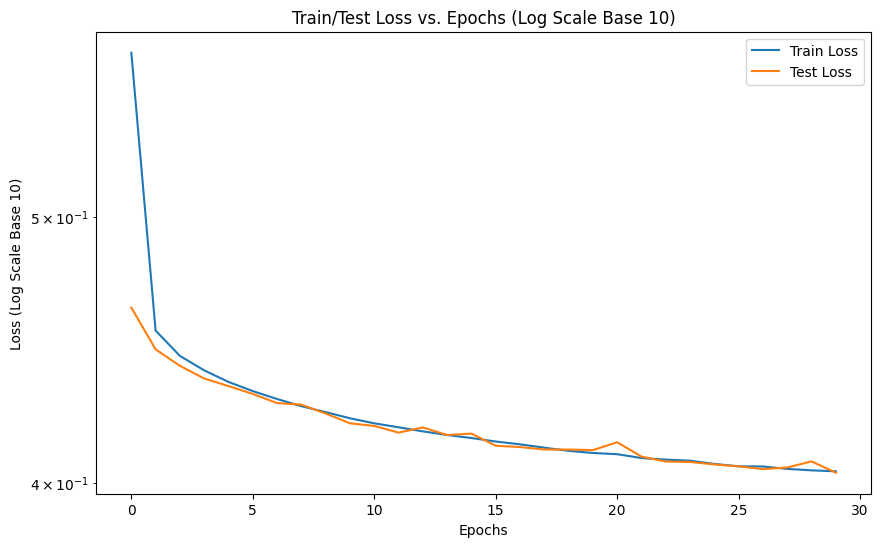

In [16]:
# Plotting the training and testing loss on a log scale with base 10
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train/Test Loss vs. Epochs (Log Scale Base 10)')
plt.xlabel('Epochs')
plt.ylabel('Loss (Log Scale Base 10)')
plt.yscale('log')
plt.legend()
plt.show()

## Encode + Save

In [17]:
autoencoder.eval()

def encode_dataset(dataloader):
    encoded_features = []
    labels_list = []

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            encoded = autoencoder.encoder(inputs).cpu().numpy()
            encoded_features.extend(encoded)
            labels_list.extend(labels.numpy())

    return np.array(encoded_features), np.array(labels_list)


In [40]:
autoencoder.eval()

def encode_dataset(dataloader, device = "mps"):
    encoded_features = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            encoded = autoencoder.encoder(inputs).cpu().numpy()
            encoded_features.extend(encoded)
            labels_list.extend(labels.cpu().numpy())

    return np.array(encoded_features), np.array(labels_list)

In [19]:
encoded_train, labels_train = encode_dataset(train_loader)
encoded_test, labels_test = encode_dataset(test_loader)

In [20]:
combined_train = np.hstack((encoded_train, labels_train.reshape(-1, 1)))
combined_test = np.hstack((encoded_test, labels_test.reshape(-1, 1)))

In [21]:
np.save('ae_encoded_train_with_labels.npy', combined_train)
np.save('ae_encoded_test_with_labels.npy', combined_test)
